In [1]:
import psyplot.project as psy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

base_path = '/work/bd1179/b309170/esmvaltool_output/from_swiftbrowser'

INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


#### Comparison of ICON-ML with ICON-A, ICON-ML+4K with ICON-A+4K; where are the biggest differences?

In [2]:
paths = {}
paths['icon_nat'] = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/'
# paths['icon_nat_4K'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov1_long_sst+4k/'
paths['icon_ml'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long/'
paths['icon_ml_4K'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long_sst+4k/'

keys = list(paths.keys())

In [3]:
# Start with 2D data
data_2d = {}
for key in keys:
    # All 2D data
    data_2d[key] = xr.open_mfdataset(paths[key] + '/*atm_2d_ml*.nc')

# We are interested in the difference of ICON-ML and ICON
data_2d['icon_diff'] = data_2d['icon_ml'] - data_2d['icon_nat']

In [4]:
# Exclude time steps
DS_excluded = data_2d['icon_diff'].isel(time=slice(1, None))  # Removes the first time step

rel_diffs = {}

for var_name in DS_excluded.data_vars:
    if var_name in ['clon_bnds', 'clat_bnds']:
        continue

    # Compute the temporal mean for each variable (over the 'time' dimension)
    temporal_mean = getattr(DS_excluded, var_name).mean(dim='time')

    # Compute the overall mean for each variable
    overall_mean = getattr(data_2d['icon_nat'].isel(time=slice(1, None)), var_name).mean()

    # Compute the relative measure (temporal mean divided by overall mean)
    rel_diffs[var_name] = temporal_mean / overall_mean

In [5]:
# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

##### ICON-ML vs ICON-A 2D variables, relative differences

<Figure size 2000x2500 with 0 Axes>

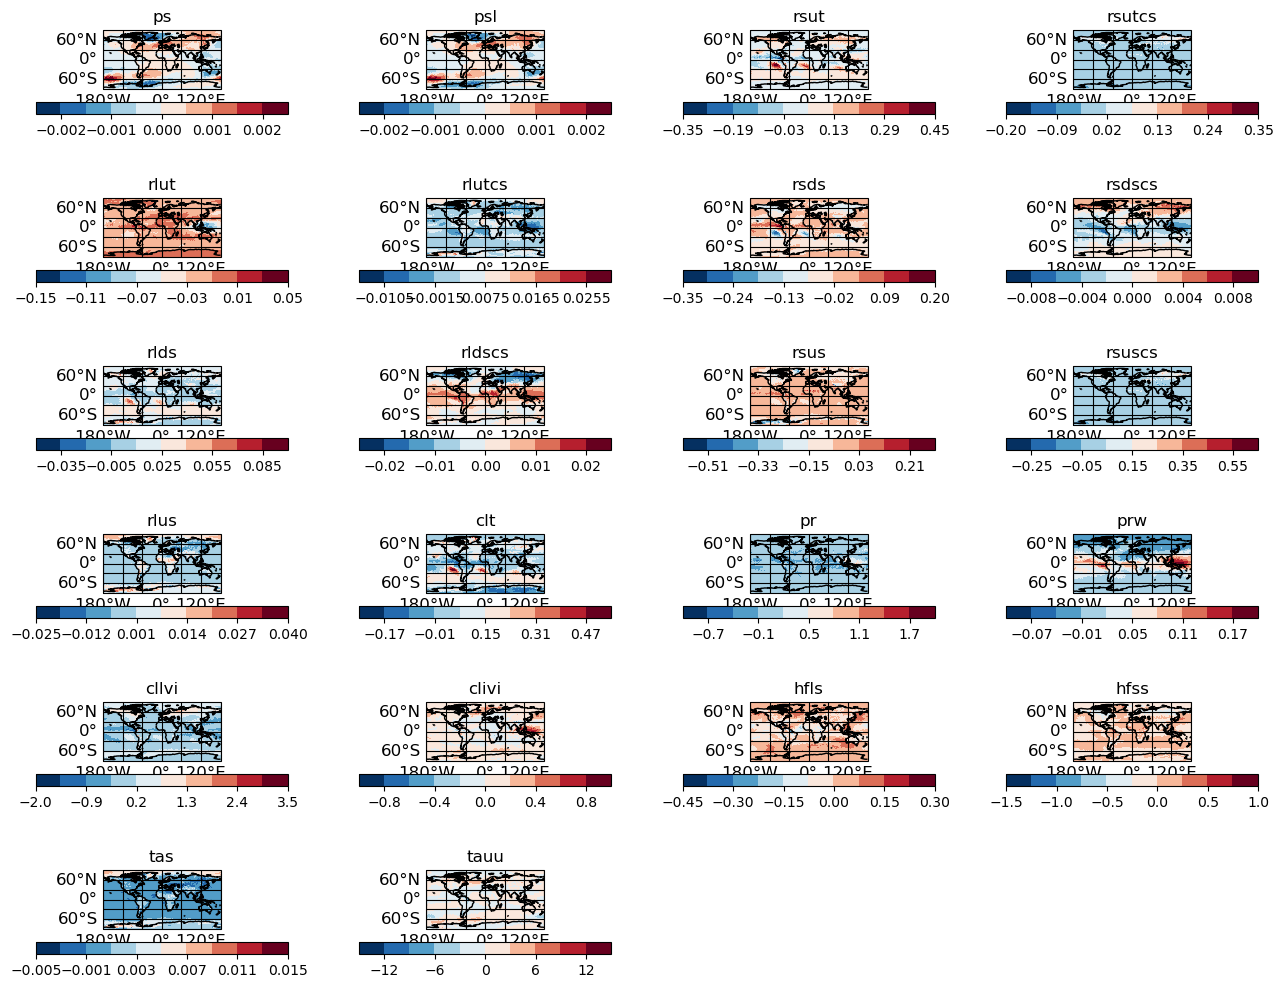

In [6]:
# Variables to loop through
all_vars = list(rel_diffs.keys())
n_plots = len(all_vars)

plt.figure(figsize=(20, 25))

# Define subplots 
ax = list(psy.multiple_subplots(rows=n_plots//4 + 1, cols=4, n=n_plots-1, for_maps=True))

plot_ind = 0
for var in all_vars:
    if var == 'rsdt': # Is all 0
        continue
    file_template.clt.values[0] = rel_diffs[var].values
    psy.plot.mapplot(file_template, name='clt', title=var, time = [0], ax = ax[plot_ind], cmap='RdBu_r')
    plot_ind = plot_ind + 1

plt.subplots_adjust(hspace=1, wspace=0.2)

Focusing in on the largest relative differences

<Figure size 1500x1000 with 0 Axes>

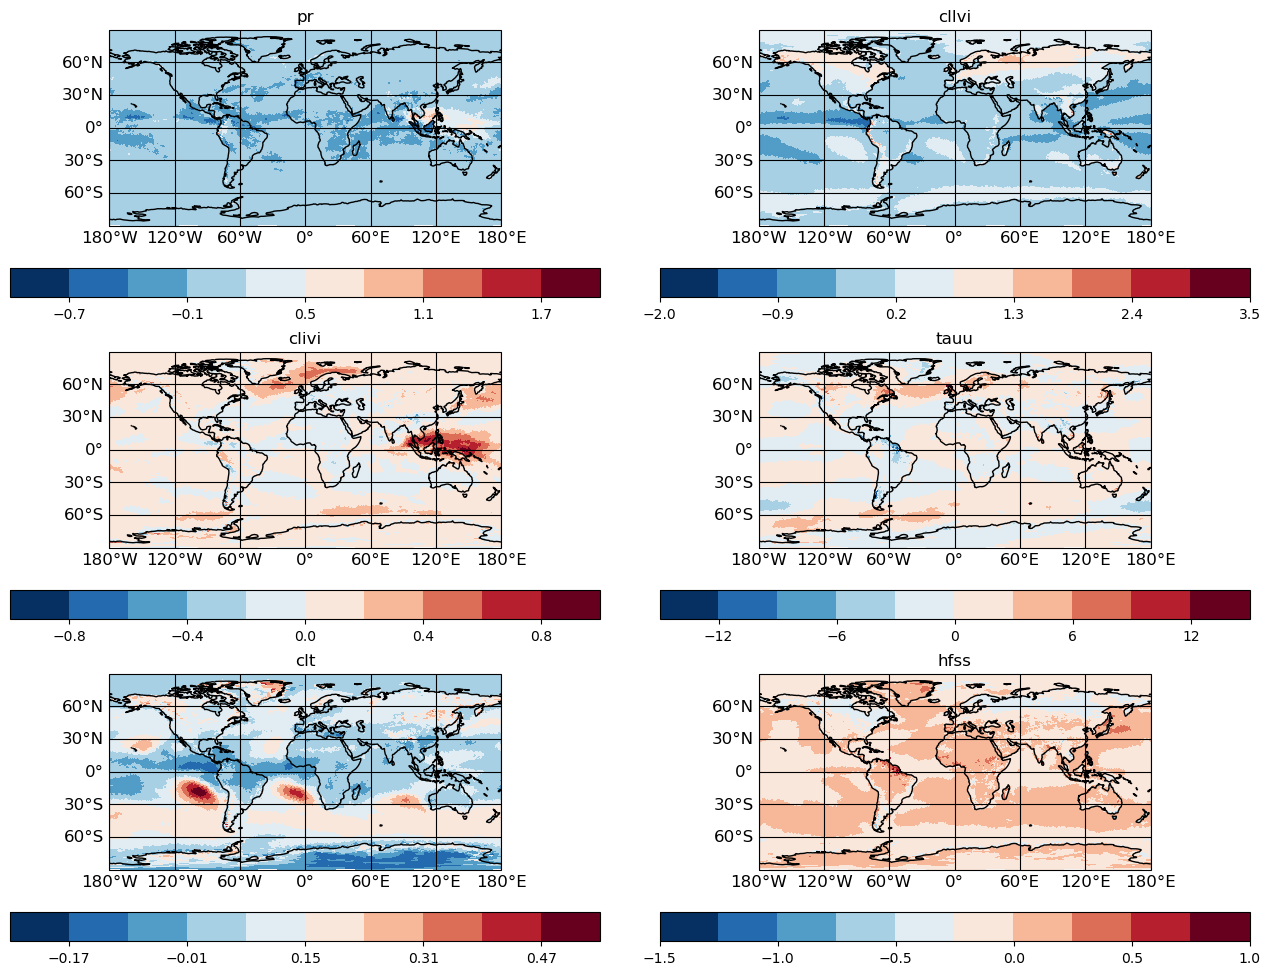

In [11]:
# Variables to loop through
all_vars = list(rel_diffs.keys())
n_plots = len(all_vars)

plt.figure(figsize=(15, 10))

# Define subplots 
ax = list(psy.multiple_subplots(rows=3, cols=2, n=6, for_maps=True))

plot_ind = 0
for var in ['pr', 'cllvi', 'clivi', 'tauu', 'clt', 'hfss']:
    if var == 'rsdt': # Is all 0
        continue
    file_template.clt.values[0] = rel_diffs[var].values
    psy.plot.mapplot(file_template, name='clt', title=var, time = [0], ax = ax[plot_ind], cmap='RdBu_r')
    plot_ind = plot_ind + 1

plt.subplots_adjust(hspace=0.15, wspace=0.1)

#### Bias plots of ICON-ML vs ICON-A of different variables
Variables considered so far: clt, pr, swcre, lwcre

**First we need to get the numbers from the esmvaltool evaluation runs**

--> Not needed for ICON-A this time as those are stored in our experiments folder...

##### Cloud Cover

<xarray.DataArray 'unknown' ()>
array(39.77437973)
Coordinates:
    time     datetime64[ns] ...
<xarray.DataArray 'unknown' ()>
array(46.59595871)
Coordinates:
    time     datetime64[ns] ...


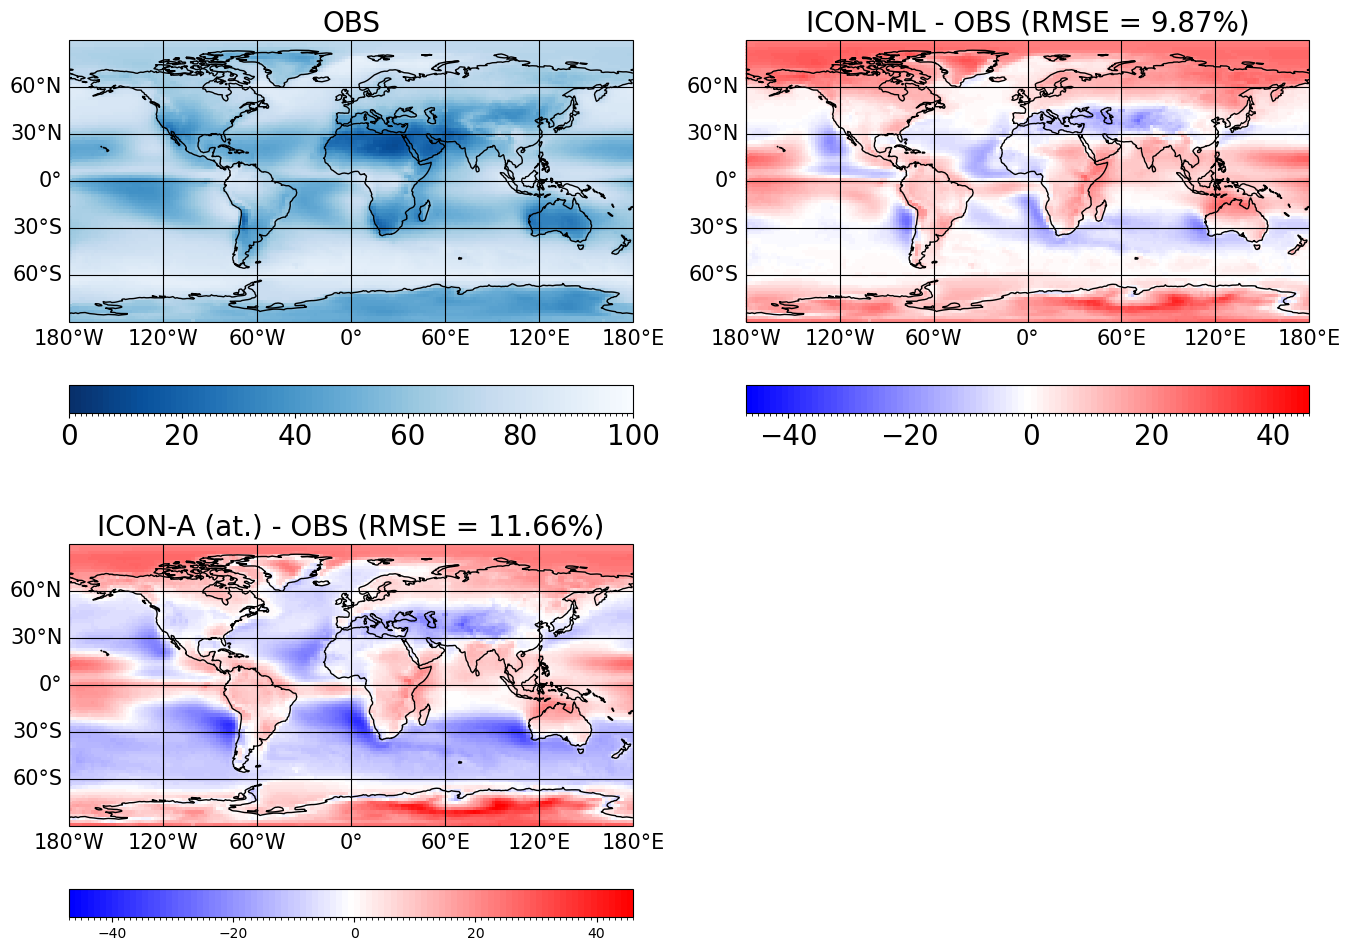

In [ ]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_top_right.nc'%path, ax = ax[plot_ind],
                        name='clt', title='OBS', cmap='Blues_r', bounds = np.arange(0,100.1), cticks=np.arange(0, 100.1, 20), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path)
        print(np.max(np.abs(data.unknown)))
        # From https://swiftbrowser.dkrz.de/objects/iconeval/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/plots/maps_clt/plot/
        rmse = 9.87 # Be careful NOT to take the sqrt_mean here as the data is in latlon (180/90). For separate computation (not from the URL above) see next line.
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-ML - OBS (RMSE = %.2f%s)'%(rmse, '%%'), cmap='bwr', cticksize=20, bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Automatically tuned ICON-A
        path = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_20241202_141113UTC/esmvaltool_output/recipe_clouds_maps_20241202_141300/work/maps_clt/plot'
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_clt_ICON_Amon_bottom.nc'%path)
        print(np.max(np.abs(data.unknown)))
        # From https://swiftbrowser.dkrz.de/objects/iconeval/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/recipe_clouds_maps_20241206_115204/plots/maps_clt/plot/
        rmse = 11.66
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_clt_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A (at.) - OBS (RMSE = %.2f%s)'%(rmse, '%%'), cmap='bwr', bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), titlesize=20, grid_labelsize=15)

In [110]:
# Global RMSE 
path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
DS = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path)
clt = DS.unknown.values

# Create np array with grid cell sizes 
cell_sizes = np.zeros((90, 180))
cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), 180, axis=1)

# Earth surface area around 510 Mio (km)^2
assert np.abs(np.sum(cell_sizes) - 510e6) < 1e5

rmse_global_ML = np.sqrt(np.sum((clt)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A-MLe:')
print(rmse_global_ML)

#####

path = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_20241202_141113UTC/esmvaltool_output/recipe_clouds_maps_20241202_141300/work/maps_clt/plot'
DS_ICONA = xr.open_dataset('%s/map_ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_clt_ICON_Amon_bottom.nc'%path)
clt = DS_ICONA.unknown.values

# Create np array with grid cell sizes 
cell_sizes = np.zeros((90, 180))
cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_ICONA.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), 180, axis=1)

# Earth surface area around 510 Mio (km)^2
assert np.abs(np.sum(cell_sizes) - 510e6) < 1e5

rmse_global = np.sqrt(np.sum((clt)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A (at.):')
print(rmse_global)

print('Bias reduction by %.3f percent'%(100*((rmse_global - rmse_global_ML)/rmse_global)))

For ICON-A-MLe:
9.865568925772342
For ICON-A (at.):
11.655955738148526
Bias reduction by 15.360 percent


In [109]:
# Southern Ocean
DS_SO = DS.sel(lat=slice(-65, -45), lon=slice(1, 360))
clt_SO = DS_SO.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_SO.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_SO.shape[1], axis=1)

rmse_SO_ML = np.sqrt(np.sum((clt_SO)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A-MLe:')
print(rmse_SO_ML)

#####

DS_SO = DS_ICONA.sel(lat=slice(-65, -45), lon=slice(1, 360))
clt_SO = DS_SO.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_SO.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_SO.shape[1], axis=1)

rmse_SO = np.sqrt(np.sum((clt_SO)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A (at.):')
print(rmse_SO)

print('Bias reduction by %.3f percent'%(100*((rmse_SO - rmse_SO_ML)/rmse_SO)))

For ICON-A-MLe:
2.317724483634985
For ICON-A (at.):
9.582600367202513
Bias reduction by 75.813 percent


In [108]:
# Chile/Peru West Coast
DS_CHI = DS.sel(lat=slice(-30, -10), lon=slice(265, 285))
clt_CHI = DS_CHI.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_CHI.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_CHI.shape[1], axis=1)

rmse_CHI_ML = np.sqrt(np.sum((clt_CHI)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A-MLe:')
print(rmse_CHI_ML)

#####

DS_CHI = DS_ICONA.sel(lat=slice(-30, -10), lon=slice(265, 285))
clt_CHI = DS_CHI.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_CHI.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_CHI.shape[1], axis=1)

rmse_CHI = np.sqrt(np.sum((clt_CHI)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A (at.):')
print(rmse_CHI)

print('Bias reduction by %.3f percent'%(100*((rmse_CHI - rmse_CHI_ML)/rmse_CHI)))

For ICON-A-MLe:
11.940542971390148
For ICON-A (at.):
23.854281804075832
Bias reduction by 49.944 percent


In [107]:
# Namibia/Angola West Coast
DS_NAM = DS.sel(lat=slice(-30, -10), lon=slice(170, 190))
clt_NAM = DS_NAM.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_NAM.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_NAM.shape[1], axis=1)

rmse_NAM_ML = np.sqrt(np.sum((clt_NAM)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A-MLe:')
print(rmse_NAM_ML)

#####

DS_NAM = DS_ICONA.sel(lat=slice(-30, -10), lon=slice(170, 190))
clt_NAM = DS_NAM.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_NAM.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_NAM.shape[1], axis=1)

rmse_NAM = np.sqrt(np.sum((clt_NAM)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A (at.):')
print(rmse_NAM)

print('Bias reduction by %.3f percent'%(100*((rmse_NAM - rmse_NAM_ML)/rmse_NAM)))

For ICON-A-MLe:
8.768364591936008
For ICON-A (at.):
10.895455728579865
Bias reduction by 19.523 percent


In [106]:
# California West Coast
DS_CAL = DS.sel(lat=slice(15, 35), lon=slice(220, 240))
clt_CAL = DS_CAL.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_CAL.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_CAL.shape[1], axis=1)

rmse_CAL_ML = np.sqrt(np.sum((clt_CAL)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A-MLe:')
print(rmse_CAL_ML)

#####

DS_CAL = DS_ICONA.sel(lat=slice(15, 35), lon=slice(220, 240))
clt_CAL = DS_CAL.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_CAL.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_CAL.shape[1], axis=1)

rmse_CAL = np.sqrt(np.sum((clt_CAL)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A (at.):')
print(rmse_CAL)

print('Bias reduction by %.3f percent'%(100*((rmse_CAL - rmse_CAL_ML)/rmse_CAL)))

For ICON-A-MLe:
12.37043961397855
For ICON-A (at.):
16.29616675033472
Bias reduction by 24.090 percent


In [105]:
# Morocco West Coast
DS_MOR = DS.sel(lat=slice(10, 30), lon=slice(315, 335))
clt_MOR = DS_MOR.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_MOR.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_MOR.shape[1], axis=1)

rmse_MOR_ML = np.sqrt(np.sum((clt_MOR)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A-MLe:')
print(rmse_MOR_ML)

#####

DS_MOR = DS_ICONA.sel(lat=slice(10, 30), lon=slice(315, 335))
clt_MOR = DS_MOR.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_MOR.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_MOR.shape[1], axis=1)

rmse_MOR = np.sqrt(np.sum((clt_MOR)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A (at.):')
print(rmse_MOR)

print('Bias reduction by %.3f percent'%(100*((rmse_MOR - rmse_MOR_ML)/rmse_MOR)))

For ICON-A-MLe:
10.122206424390892
For ICON-A (at.):
17.37991340703309
Bias reduction by 41.759 percent


In [104]:
# Australia West Coast
DS_AUS = DS.sel(lat=slice(-40, -20), lon=slice(90, 110))
clt_AUS = DS_AUS.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_AUS.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_AUS.shape[1], axis=1)

rmse_AUS_ML = np.sqrt(np.sum((clt_AUS)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A-MLe:')
print(rmse_AUS_ML)

#####

DS_AUS = DS_ICONA.sel(lat=slice(-40, -20), lon=slice(90, 110))
clt_AUS = DS_AUS.unknown.values

cell_sizes_per_lat = 6371**2*(np.pi/90)**2*np.cos(DS_AUS.lat.values/180*np.pi) # in (km)^2
cell_sizes = np.repeat(np.expand_dims(cell_sizes_per_lat, axis=1), clt_AUS.shape[1], axis=1)

rmse_AUS = np.sqrt(np.sum((clt_AUS)**2*cell_sizes)/np.sum(cell_sizes)) 
print('For ICON-A (at.):')
print(rmse_AUS)

print('Bias reduction by %.3f percent'%(100*((rmse_AUS - rmse_AUS_ML)/rmse_AUS)))

For ICON-A-MLe:
12.048975917490388
For ICON-A (at.):
25.795843486957885
Bias reduction by 53.291 percent


In [111]:
# Average reduction in subtropical stratocumulus decks
(49.944 + 19.523 + 24.090 + 41.759 + 53.291)/5

37.7214

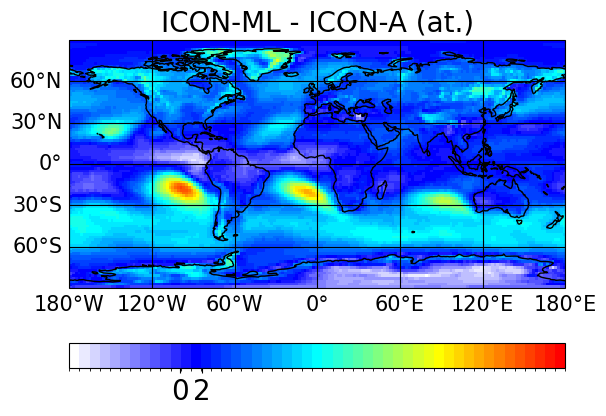

In [20]:
# Tuned ICON-ML
path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_clt/plot'%base_path
data_ml = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_clt_ICON_Amon_bottom.nc'%path)
# Automatically tuned ICON-A
path = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_20241202_141113UTC/esmvaltool_output/recipe_clouds_maps_20241202_141300/work/maps_clt/plot'
data_a = xr.open_dataset('%s/map_ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_clt_ICON_Amon_bottom.nc'%path)

data_a.unknown.values = data_ml.unknown.values - data_a.unknown.values

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "lat_bnds", "lon_bnds"]
data_a = data_a.set_coords([coord for coord in data_a.data_vars if coord in coordlist])

psy.plot.mapplot(data_a, title='ICON-ML - ICON-A (at.)', name='unknown', cticksize=20, titlesize=20, grid_labelsize=15, bounds=np.linspace(-10.1, 35.1, 50), cticks=[0,2])

cb = plt.gcf().colorbar

##### SWCRE - from ESMValTool output

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':
/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


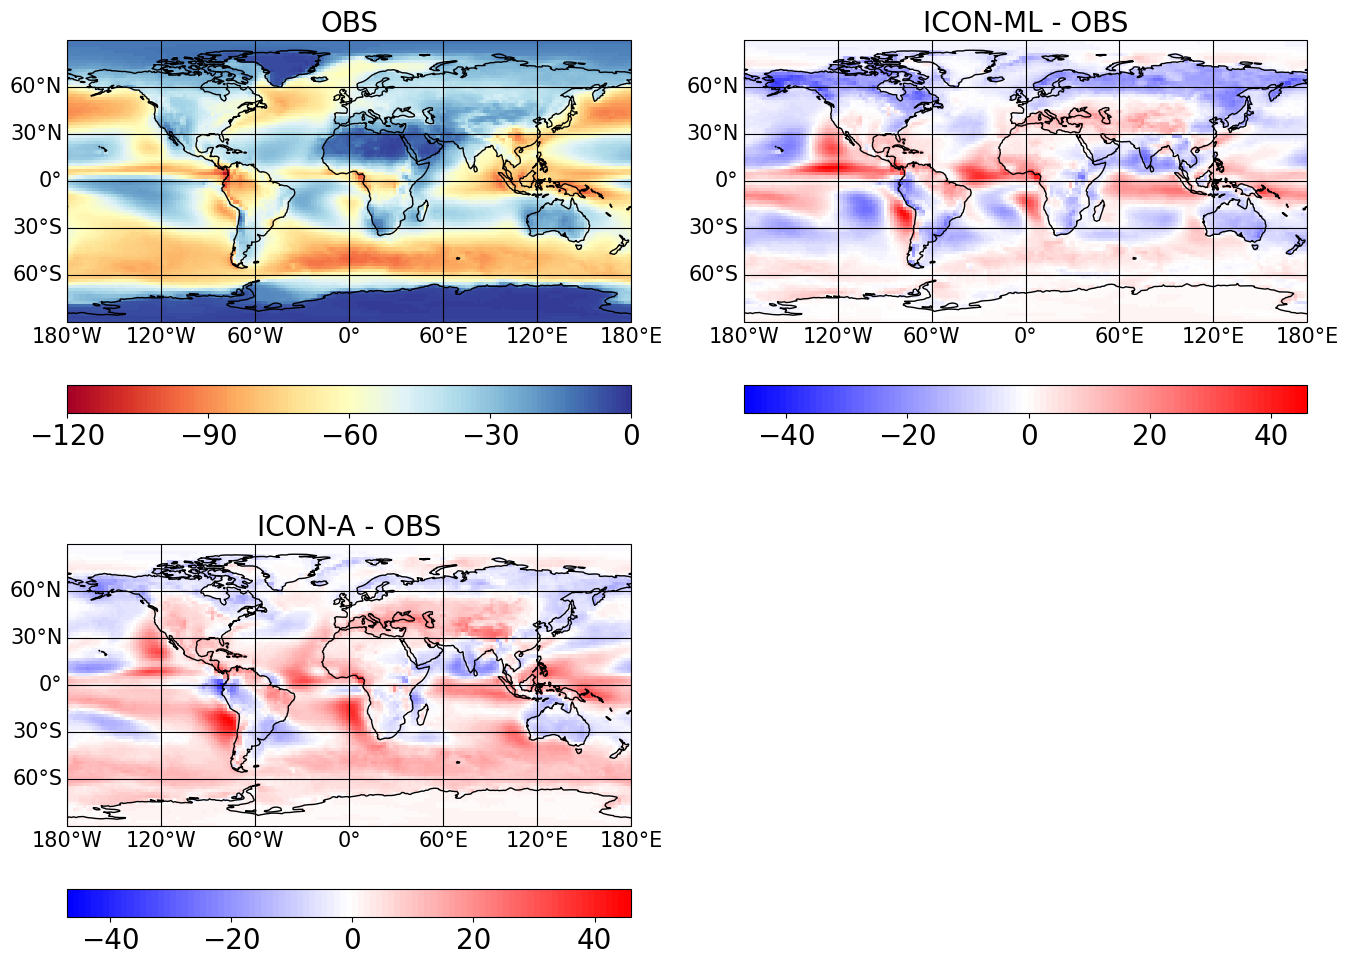

In [16]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_swcre/plot'%base_path
        ds = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_top_right.nc'%path)
        vmin = int(ds.swcre.min()) - 1 # 116
        vmax = int(ds.swcre.max()) + 1 # 0 
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_top_right.nc'%path, ax = ax[plot_ind],
                        name='swcre', title='OBS', cmap='RdYlBu', bounds = np.arange(-120,0.01), cticks=np.arange(-120,0.01, 30), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_swcre/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_swcre_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-ML - OBS', cmap='bwr', bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), cticksize=20,titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Tuned ICON-A
        path = '/home/b/b309170/bd1179_work/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_20241202_141113UTC/esmvaltool_output/recipe_clouds_maps_20241202_141300/work/maps_swcre/plot'
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_swcre_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A - OBS', cmap='bwr', bounds = np.arange(-47,47), cticks=np.arange(-40, 60, 20), cticksize=20, titlesize=20, grid_labelsize=15)


**LWCRE**

Have to be careful to exclude ERA5

In [ ]:
float(ds.rlut.max())

In [207]:
ds = xr.open_dataset('/work/bd1179/b309170/from_esmvaltool/OBS_lwcre_mean_sign.nc')

In [ ]:
# Compute the reference OBS LWCRE first (from lwcre: ESACCI-CLOUD (19970101/20161231))

# # Moderate quality data, high resolution
# esacci_rlut = xr.open_mfdataset('/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ESACCI-CLOUD/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rlut_198201-201612.nc')
# esacci_rlutcs = xr.open_mfdataset('/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ESACCI-CLOUD/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rlutcs_198201-201612.nc')
# esacci_lwcre = esacci_rlutcs.rlutcs - esacci_rlut.rlut

In [ ]:
path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_clouds_maps_20240930_141234/work/maps_lwcre/plot'%base_path
'%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_lwcre_ICON_Amon_top_left.nc'%path

In [ ]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        psy.plot.mapplot('/work/bd1179/b309170/from_esmvaltool/OBS_lwcre_mean_sign.nc', ax = ax[plot_ind],
                        name='rlut', title='OBS', cmap='Reds', bounds = np.arange(2, 74, 1), cticks=np.arange(2, 74.01, 10), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        psy.plot.mapplot('/work/bd1179/b309170/from_esmvaltool/ICON_ML-OBS.nc', ax = ax[plot_ind],
                        name='unknown', title='ICON-ML - OBS', cmap='bwr', cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Tuned ICON-A
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_clouds_maps_20240930_133920/work/maps_lwcre/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_lwcre_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A - OBS', cmap='bwr', cticksize=20, titlesize=20, grid_labelsize=15)


##### Precipitation

In [ ]:
# Define subplots 
ax = list(psy.multiple_subplots(rows=2, cols=2, n=3, for_maps=True))

# Second subplot: Plotting ICON data
for plot_ind in range(3):
    
    if plot_ind == 0:
        # OBS
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_basics_maps_20240930_134550/work/maps_pr/plot'%base_path
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_top_right.nc'%path, ax = ax[plot_ind],
                        name='pr', title='OBS', cmap='Blues', bounds = np.arange(0, 13, 0.01), cticks=np.arange(0, 13, 2), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 1:
        # Tuned ICON-ML
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/recipe_basics_maps_20240930_134550/work/maps_pr/plot'%base_path
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_bottom.nc'%path)
        rmse = np.sqrt(np.mean(data.unknown**2))
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927_pr_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-ML - OBS (LATLON_RMSE=%.3f)'%rmse, cmap='bwr', bounds = np.arange(-10, 10.01, 0.1), cticks=np.arange(-10, 10.01, 5), cticksize=20, titlesize=20, grid_labelsize=15)
    elif plot_ind == 2:
        # Tuned ICON-A
        path = '%s/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs/recipe_basics_maps_20240930_133811/work/maps_pr/plot'%base_path
        data = xr.open_dataset('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_pr_ICON_Amon_bottom.nc'%path)
        rmse = np.sqrt(np.mean(data.unknown**2))
        psy.plot.mapplot('%s/map_ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_20yrs_pr_ICON_Amon_bottom.nc'%path, ax = ax[plot_ind],
                        name='unknown', title='ICON-A - OBS (LATLON_RMSE=%.3f)'%rmse, cmap='bwr', bounds = np.arange(-10, 10.01, 0.1), cticks=np.arange(-10, 10.01, 5), cticksize=20, titlesize=20, grid_labelsize=15)

##### Precipitation - South East Asian summer monsoon

Focus on 60E – 120E, 20S – 30N. In the NH, the summer and winter are defined as May–June-July-August-September (MJJAS) and November–December-January-February-March 

In [57]:
# TURN THIS INTO A METHOD - CALCULATE FOR ICON-A, ICON-ML, GPCP OBS

# Define spatial bounds
latitude_bounds = slice(-20, 30)  # Latitude from 20°S to 30°N
longitude_bounds = slice(60, 120)  # Longitude from 60°E to 120°E

# Define months for NH and SH summers
nh_summer_months = [5, 6, 7, 8, 9]  # May to September
sh_summer_months = [11, 12, 1, 2, 3]  # November to March

# Select region
regional_data = data_2d['icon_ml'].pr.where(
    (data_2d['icon_ml'].clat >= -20) & (data_2d['icon_ml'].clat <= 30) &
    (data_2d['icon_ml'].clon >= 60) & (data_2d['icon_ml'].clon <= 120),
    drop=True
)

# Separate data for NH and SH based on latitude. Use .where() to filter based on clat coordinate values from 0 to 30
nh_data = regional_data.where((regional_data.clat >= 0) & (regional_data.clat <= 30), drop=True)
sh_data = regional_data.where((regional_data.clat >= -20) & (regional_data.clat <= 0), drop=True)

# Convert time dimension to datetime format if it's not already
nh_data['time'] = xr.cftime_range(start='1979-01-01', end='1999-01-01', freq='MS')
sh_data['time'] = xr.cftime_range(start='1979-01-01', end='1999-01-01', freq='MS')

# Define NH and SH summer months
nh_summer_months = [5, 6, 7, 8, 9]      # May to September
sh_summer_months = [11, 12, 1, 2, 3]    # November to March

# Select only summer months using .where() and .dt.month accessor
nh_summer = nh_data.where(nh_data['time.month'].isin(nh_summer_months), drop=True)
sh_summer = sh_data.where(sh_data['time.month'].isin(sh_summer_months), drop=True)

# Filter for NH summer months and calculate mean
nh_summer_avg = nh_summer.mean(dim='time')

# Filter for SH summer months and calculate mean
sh_summer_avg = sh_summer.mean(dim='time')

In [58]:
nh_summer_avg

<xarray.DataArray 'pr' (ncells: 0)>
dask.array<mean_agg-aggregate, shape=(0,), dtype=float32, chunksize=(0,), chunktype=numpy.ndarray>
Coordinates:
    clon     (ncells) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(0,), meta=np.ndarray>
Dimensions without coordinates: ncells

In [17]:
# OBS from GPCP-SG
data_2d['icon_ml'].pr

<xarray.DataArray 'pr' (time: 241, ncells: 81920)>
dask.array<concatenate, shape=(241, 81920), dtype=float32, chunksize=(12, 81920), chunktype=numpy.ndarray>
Coordinates:
    clon     (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
    clat     (ncells) float32 dask.array<chunksize=(81920,), meta=np.ndarray>
  * time     (time) float64 1.979e+07 1.979e+07 ... 1.998e+07 1.999e+07
Dimensions without coordinates: ncells
Attributes:
    standard_name:                pr
    long_name:                    precipitation flux
    units:                        kg m-2 s-1
    param:                        52.1.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

##### Preprocess obs and set bounds

In [2]:
import subprocess

def remap_esacci_var(var_name):
    ## Remaps ESACCI data and returns the remapped dataset

    # Have rsdt, rlutcs, rsut, rlut, rsutcs, clivi, rlus, cltStderr, rsus, clwvi, clt, rsuscs, lwp at our disposition    
    esacci_rad_file="/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ESACCI-CLOUD/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612.nc"%var_name
    some_iconml_file="/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_atm_2d_ml_19810101T000000Z.nc"
    target_file_esacci="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612_r2b5.nc"%var_name
    target_file_int="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612_r2b5_int.nc"%var_name
    target_file_int2="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_%s_198201-201612_r2b5_int2.nc"%var_name

    subprocess.run('module load cdo', check=True, shell=True)
    subprocess.run(['cdo','seltimestep,1/216', esacci_rad_file, target_file_int2], check=True) # Select proper timerange (up to and including 2000)
    subprocess.run(['cdo','timmean', target_file_int2, target_file_int], check=True)
    subprocess.run(['cdo', 'remapcon,' + some_iconml_file, target_file_int, target_file_esacci], check=True)
    subprocess.run(['rm', target_file_int], check=True)
    subprocess.run(['rm', target_file_int2], check=True)

    # Load preprocessed OBS data
    obs_rad = getattr(xr.open_dataset(target_file_esacci), var_name)[0]

    return obs_rad

def remap_isccp_var(var_name):
    ## Remaps ISCCP rad. data and returns the remapped dataset

    # Have rlut, rsut, alb, prw, ps, rsutcs, rlutcs, rsdt, rsds, rlus, rlds at our disposition    
    isccp_rad_file="/work/bd0854/DATA/ESMValTool2/OBS/Tier2/ISCCP-FH/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612.nc"%var_name
    some_iconml_file="/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs_atm_2d_ml_19810101T000000Z.nc"
    target_file_isccp="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612_r2b5.nc"%var_name
    target_file_int="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612_r2b5_int.nc"%var_name
    target_file_int2="/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ISCCP-FH_sat_v0_Amon_%s_198401-201612_r2b5_int2.nc"%var_name

    subprocess.run('module load cdo', check=True, shell=True)
    subprocess.run(['cdo','seltimestep,1/196', isccp_rad_file, target_file_int2], check=True) # Select proper timerange (up to and including 2000)
    subprocess.run(['cdo','timmean', target_file_int2, target_file_int], check=True)
    subprocess.run(['cdo', 'remapcon,' + some_iconml_file, target_file_int, target_file_isccp], check=True)
    subprocess.run(['rm', target_file_int], check=True)
    subprocess.run(['rm', target_file_int2], check=True)

    # Load preprocessed OBS data
    obs_rad = getattr(xr.open_dataset(target_file_isccp), var_name)[0]

    return obs_rad

def preprocess_obs(var_name = 'rlut'):
    '''
        Get observations for radiation.
    '''
    ## OBS data. Load preprocessed OBS data
    if var_name in ['rlut', 'rsut']: # ESACCI + ISCCP as OBS
        obs_rad1 = remap_esacci_var(var_name)
        obs_rad2 = remap_isccp_var(var_name)
    elif var_name == 'lwcre':
        # ESACCI
        rlutcs = remap_esacci_var('rlutcs')
        rlut = remap_esacci_var('rlut')
        obs_rad1 = rlutcs - rlut
        # ISCCP
        rlutcs = remap_isccp_var('rlutcs')
        rlut = remap_isccp_var('rlut')
        obs_rad2 = rlutcs - rlut
    elif var_name ==  'swcre':
        # ESACCI
        rsutcs = remap_esacci_var('rsutcs')
        rsut = remap_esacci_var('rsut')
        obs_rad1 = rsutcs - rsut
        # ISCCP
        rsutcs = remap_isccp_var('rsutcs')
        rsut = remap_isccp_var('rsut')
        obs_rad2 = rsutcs - rsut
    elif var_name in ['clivi', 'lwp']: # Only consider ESACCI as OBS
        obs_rad1 = remap_esacci_var(var_name)
        obs_rad2 = obs_rad1 
    return (obs_rad1 + obs_rad2)/2

# Great methods to automatically set proper bounds and cticks!
def set_cticks(data, div=False):
    # Assuming max >= 0
    max = float(np.max(data))
    min = float(np.min(data))
    if div:
        max = np.maximum(np.abs(min), np.abs(max))
        if max > 50:
            max = int(np.ceil(max))
        min = -max
    cticks = np.arange(min, max+max/100, (max - min)/5)
    cticks = [float('%.1f'%cticks[i]) for i in range(len(cticks))]
    return cticks

def set_bounds(data, div=False):
    max = np.max(data)
    min = np.min(data)
    if div:
        max = np.maximum(np.abs(min), np.abs(max))
        min = -max
    # Bounds should be chosen such that the max and min ctick are barely included
    min_ctick = set_cticks(data, div=div)[0]
    max_ctick = set_cticks(data, div=div)[-1]
    bounds = np.linspace(min_ctick - np.abs(min_ctick)/100, max_ctick+max_ctick/100, 100)
    return bounds

In [5]:
set_cticks(icona_rsut_data_avrg - obs_avrg, div=True)

[-104.0, -62.4, -20.8, 20.8, 62.4, 104.0]

In [6]:
set_bounds(icona_rsut_data_avrg - obs_avrg, div=True)

array([-105.04      , -102.9179798 , -100.7959596 ,  -98.67393939,
        -96.55191919,  -94.42989899,  -92.30787879,  -90.18585859,
        -88.06383838,  -85.94181818,  -83.81979798,  -81.69777778,
        -79.57575758,  -77.45373737,  -75.33171717,  -73.20969697,
        -71.08767677,  -68.96565657,  -66.84363636,  -64.72161616,
        -62.59959596,  -60.47757576,  -58.35555556,  -56.23353535,
        -54.11151515,  -51.98949495,  -49.86747475,  -47.74545455,
        -45.62343434,  -43.50141414,  -41.37939394,  -39.25737374,
        -37.13535354,  -35.01333333,  -32.89131313,  -30.76929293,
        -28.64727273,  -26.52525253,  -24.40323232,  -22.28121212,
        -20.15919192,  -18.03717172,  -15.91515152,  -13.79313131,
        -11.67111111,   -9.54909091,   -7.42707071,   -5.30505051,
         -3.1830303 ,   -1.0610101 ,    1.0610101 ,    3.1830303 ,
          5.30505051,    7.42707071,    9.54909091,   11.67111111,
         13.79313131,   15.91515152,   18.03717172,   20.15919

##### LW Radiation

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr0: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

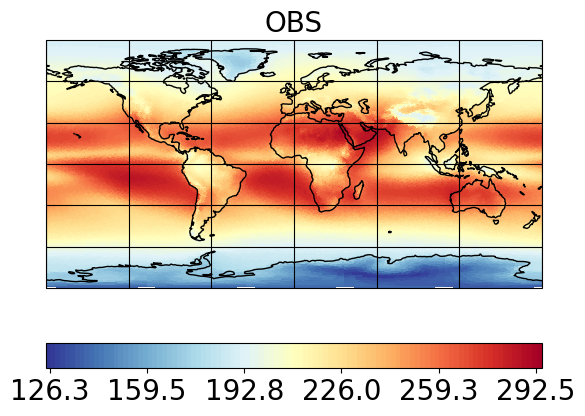

In [6]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rlut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rlut_198201-201612_r2b5.nc").rlut[0] 

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, bounds = set_bounds(obs_avrg), cticks=set_cticks(obs_avrg), titlesize=20, grid_labelsize=15, cticksize=20)

In [6]:
psy.rcParams

RcParams({'auto_draw': True,
          'auto_show': False,
          'colors.cmaps': {},
          'datapath': None,
          'decoder.interp_kind': 'linear',
          'decoder.t': {'time'},
          'decoder.x': set(),
          'decoder.y': set(),
          'decoder.z': set(),
          'gridweights.use_cdo': None,
          'lists.auto_update': True,
          'lonlatbox.boxes': {},
          'plotter.bar.alpha': 1.0,
          'plotter.bar.categorical': None,
          'plotter.bar.coord': None,
          'plotter.bar.plot': 'bar',
          'plotter.bar.widths': 'equal',
          'plotter.baseplotter.background': 'rc',
          'plotter.baseplotter.figtitle': '',
          'plotter.baseplotter.figtitleprops': {},
          'plotter.baseplotter.figtitlesize': 12.0,
          'plotter.baseplotter.figtitleweight': None,
          'plotter.baseplotter.mask': None,
          'plotter.baseplotter.maskbetween': None,
          'plotter.baseplotter.maskgeq': None,
          'plotter.

In [ ]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rlut')

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/'

icona_rlut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlut[2:]
icona_rlut_data_avrg = icona_rlut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_rlut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print(np.max(np.abs(file_template.clt.values[0])))
print('RMSE = %.4f'%rmse)
plot = psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A (at.) - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = set_bounds(icona_rlut_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(icona_rlut_data_avrg - obs_avrg, div=True), titlesize=20, grid_labelsize=15, cticksize=20)

# Access the colorbar
cbar = plot.cbar
# Disable minor ticks
cbar.ax.tick_params(which='minor', bottom=False, left=False)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid


In [4]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rlut')

# Load ICON-ML data
data_path = paths['icon_ml']

iconml_rlut_data = xr.open_mfdataset(data_path + '/*atm_2d_ml*.nc').rlut[2:]
iconml_rlut_data_avrg = iconml_rlut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_rlut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
max_abs = np.max(np.abs(file_template.clt.values[0]))
print(np.max(np.abs(file_template.clt.values[0])))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - OBS (%.2f, %.2f W/m$^2$)'%(rmse, max_abs), cmap='bwr', bounds = set_bounds(icona_rlut_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(icona_rlut_data_avrg - obs_avrg, div=True), titlesize=20, grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
48.209305
RMSE = 8.3678


NameError: name 'icona_rlut_data_avrg' is not defined

##### SW Radiation

psyplot.project.Project([    arr4: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

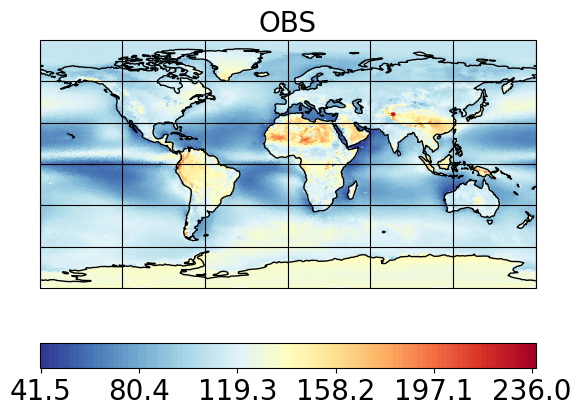

: 

In [ ]:
# Preprocess and load OBS data
# obs_avrg = preprocess_obs('rsut')
obs_avrg = xr.open_dataset("/home/b/b309170/bd1179_work/from_esmvaltool/OBS_ESACCI-CLOUD_sat_AVHRR-AMPM-fv3.0_Amon_rsut_198201-201612_r2b5.nc").rsut[0] 

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, titlesize=20, bounds = set_bounds(obs_avrg), cticks=set_cticks(obs_avrg), grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
103.047035
RMSE = 11.4110


psyplot.project.Project([    arr0: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

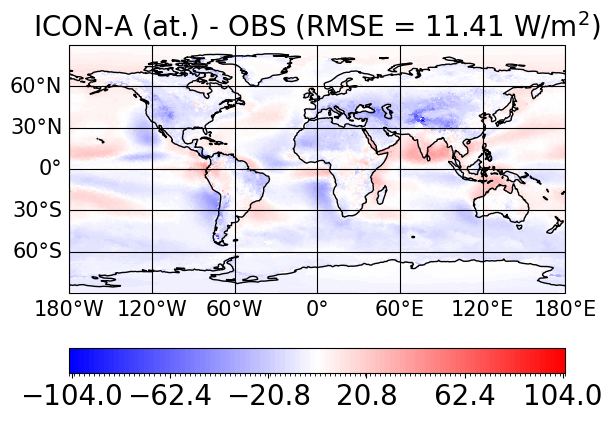

In [5]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rsut')

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/'

icona_rsut_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[2:]
icona_rsut_data_avrg = icona_rsut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_rsut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print(np.max(np.abs(file_template.clt.values[0])))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A (at.) - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = set_bounds(icona_rsut_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(icona_rsut_data_avrg - obs_avrg, div=True), titlesize=20, grid_labelsize=15, cticksize=20)

In [8]:
cticks=[-104.0, -62.4, -20.8, 20.8, 62.4, 104.0]

bounds = [-105.04      , -102.9179798 , -100.7959596 ,  -98.67393939,
        -96.55191919,  -94.42989899,  -92.30787879,  -90.18585859,
        -88.06383838,  -85.94181818,  -83.81979798,  -81.69777778,
        -79.57575758,  -77.45373737,  -75.33171717,  -73.20969697,
        -71.08767677,  -68.96565657,  -66.84363636,  -64.72161616,
        -62.59959596,  -60.47757576,  -58.35555556,  -56.23353535,
        -54.11151515,  -51.98949495,  -49.86747475,  -47.74545455,
        -45.62343434,  -43.50141414,  -41.37939394,  -39.25737374,
        -37.13535354,  -35.01333333,  -32.89131313,  -30.76929293,
        -28.64727273,  -26.52525253,  -24.40323232,  -22.28121212,
        -20.15919192,  -18.03717172,  -15.91515152,  -13.79313131,
        -11.67111111,   -9.54909091,   -7.42707071,   -5.30505051,
         -3.1830303 ,   -1.0610101 ,    1.0610101 ,    3.1830303 ,
          5.30505051,    7.42707071,    9.54909091,   11.67111111,
         13.79313131,   15.91515152,   18.03717172,   20.15919192,
         22.28121212,   24.40323232,   26.52525253,   28.64727273,
         30.76929293,   32.89131313,   35.01333333,   37.13535354,
         39.25737374,   41.37939394,   43.50141414,   45.62343434,
         47.74545455,   49.86747475,   51.98949495,   54.11151515,
         56.23353535,   58.35555556,   60.47757576,   62.59959596,
         64.72161616,   66.84363636,   68.96565657,   71.08767677,
         73.20969697,   75.33171717,   77.45373737,   79.57575758,
         81.69777778,   83.81979798,   85.94181818,   88.06383838,
         90.18585859,   92.30787879,   94.42989899,   96.55191919,
         98.67393939,  100.7959596 ,  102.9179798 ,  105.04      ]

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
94.42423
RMSE = 11.3001


psyplot.project.Project([    arr1: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

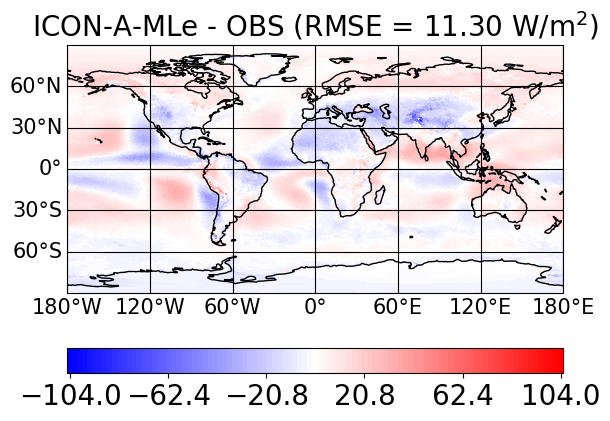

In [10]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('rsut')

# Load ICON-ML data
data_path = paths['icon_ml']

iconml_rsut_data = xr.open_mfdataset(data_path + '/*atm_2d_ml*.nc').rsut[2:]
iconml_rsut_data_avrg = iconml_rsut_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_rsut_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print(np.max(np.abs(file_template.clt.values[0])))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A-MLe - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = bounds, \
                 cticks=cticks, titlesize=20, grid_labelsize=15, cticksize=20)

##### LWCRE

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr2: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

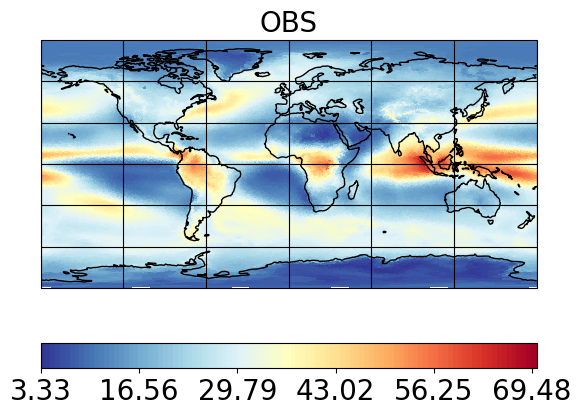

In [25]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('lwcre')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, bounds = set_bounds(obs_avrg), cticks=set_cticks(obs_avrg), titlesize=20, grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
RMSE = 5.0839


psyplot.project.Project([    arr0: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

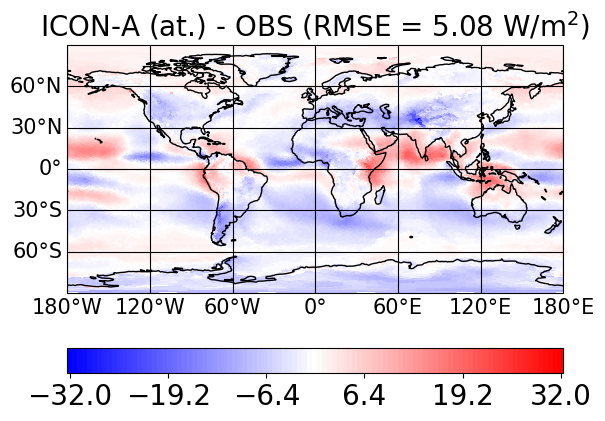

In [ ]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('lwcre')

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/'

icona_rlutcs = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlutcs[2:]
icona_rlut = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlut[2:]
icona_lwcre_data = icona_rlutcs - icona_rlut
icona_lwcre_data_avrg = icona_lwcre_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_lwcre_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A (at.) - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = set_bounds(icona_lwcre_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(icona_lwcre_data_avrg - obs_avrg, div=True), titlesize=20, grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
RMSE = 7.7125


psyplot.project.Project([    arr1: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

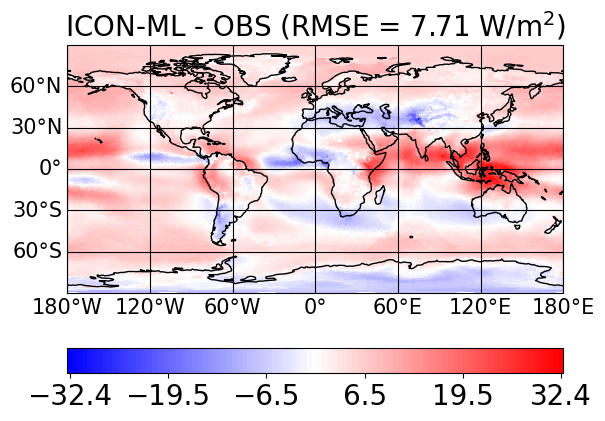

In [ ]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('lwcre')

# Load ICON-ML data
data_path = paths['icon_ml']

iconml_rlutcs = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlutcs[2:]
iconml_rlut = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rlut[2:]
iconml_lwcre_data = iconml_rlutcs - iconml_rlut
iconml_lwcre_data_avrg = iconml_lwcre_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_lwcre_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = set_bounds(iconml_lwcre_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(iconml_lwcre_data_avrg - obs_avrg, div=True), titlesize=20, grid_labelsize=15, cticksize=20)

##### SWCRE

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)


psyplot.project.Project([    arr2: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

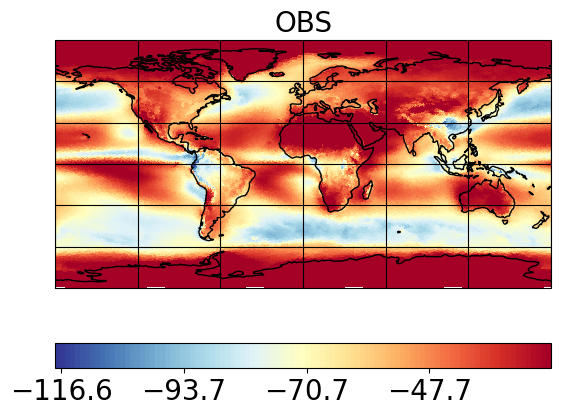

: 

In [ ]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('swcre')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, bounds = set_bounds(obs_avrg),\
                  cticks=set_cticks(obs_avrg), titlesize=20, grid_labelsize=15, cticksize=20)

In [3]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('swcre')
# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/'

icona_rsutcs = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsutcs[2:]
icona_rsut = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[2:]
icona_swcre_data = icona_rsutcs - icona_rsut
icona_swcre_data_avrg = icona_swcre_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_swcre_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
print(np.max(np.abs(file_template.clt.values[0])))
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A (at.) - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = set_bounds(icona_swcre_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(icona_swcre_data_avrg - obs_avrg, div=True), titlesize=20, grid_labelsize=15, cticksize=20)

NameError: name 'preprocess_obs' is not defined

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
cdo    remapcon: YAC first order conservative weights from lonlat (360x180) to unstructured (81920) grid, with source mask (64788)
RMSE = 11.1842


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr1: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

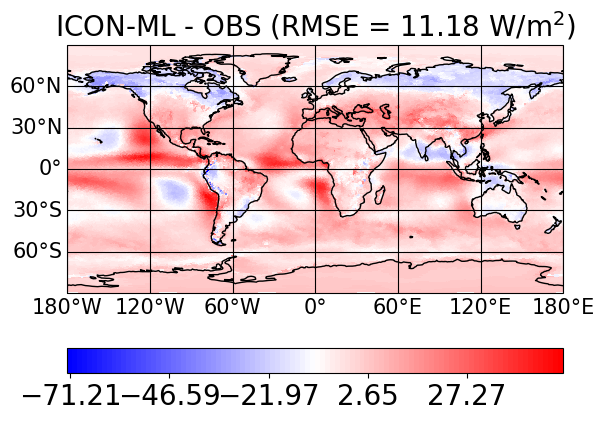

In [ ]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('swcre')

# Load ICON-ML data
data_path = paths['icon_ml']

iconml_rsutcs = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsutcs[2:]
iconml_rsut = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').rsut[2:]
iconml_swcre_data = iconml_rsutcs - iconml_rsut
iconml_swcre_data_avrg = iconml_swcre_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_swcre_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - OBS (RMSE = %.2f W/m$^2$)'%rmse, cmap='bwr', bounds = set_bounds(iconml_swcre_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(iconml_swcre_data_avrg - obs_avrg, div=True), titlesize=20, grid_labelsize=15, cticksize=20)

##### Cloud Ice

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr43: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

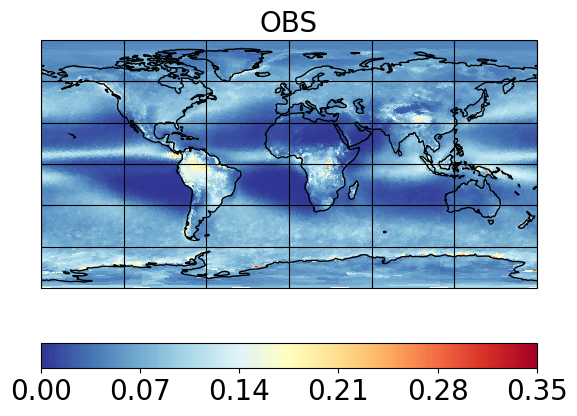

In [ ]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('clivi')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='RdYlBu_r', grid_labels = 0, titlesize=20, bounds = np.arange(0, 0.351, 0.002), \
                  cticks=np.arange(0, 0.351, 0.07),  grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
RMSE = 0.02574


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr73: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

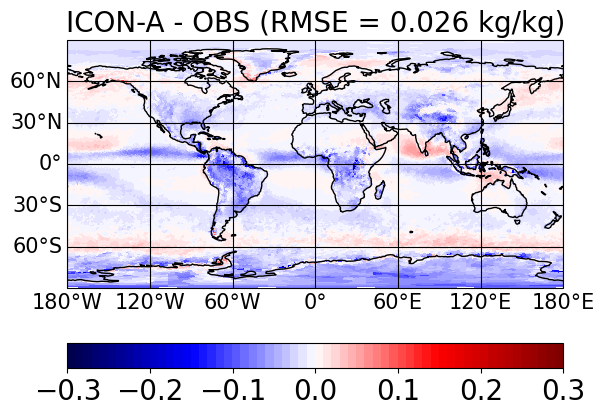

In [121]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('clivi')

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/'

icona_clivi_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').clivi[1:]
icona_clivi_data_avrg = icona_clivi_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_clivi_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4g'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A - OBS (RMSE = %.3f kg/kg)'%rmse, \
                 bounds = np.arange(-0.3, 0.31, 0.01), cticks=np.arange(-0.3, 0.31, 0.1), \
                 cmap='seismic',titlesize=20, grid_labelsize=15, cticksize=20)

RMSE = 0.02548


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr74: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

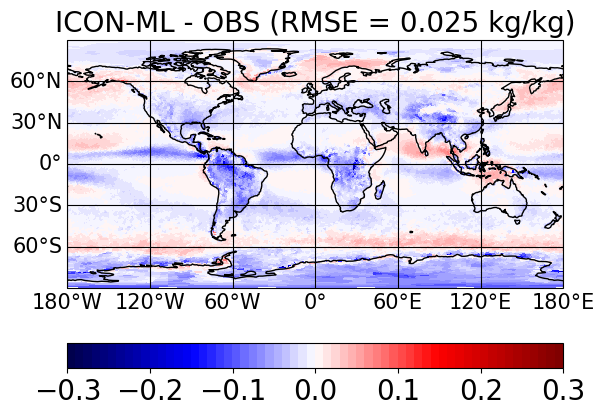

In [122]:
# Load ICON-ML data
data_path = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long/'

iconml_clivi_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').clivi[1:]
iconml_clivi_data_avrg = iconml_clivi_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_clivi_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4g'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - OBS (RMSE = %.3f kg/kg)'%rmse, cmap='seismic',titlesize=20, \
                 bounds = np.arange(-0.3, 0.31, 0.01), cticks=np.arange(-0.3, 0.31, 0.1), grid_labelsize=15, cticksize=20)

RMSE = 0.006821


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr79: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

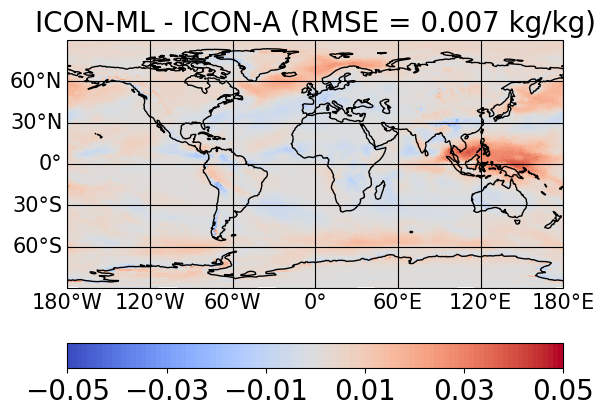

In [127]:
# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_clivi_data_avrg - icona_clivi_data_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.6f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - ICON-A (RMSE = %.3f kg/kg)'%rmse, cmap='coolwarm',titlesize=20, bounds = np.arange(-0.05,0.051,0.001), \
                 cticks=np.arange(-0.05,0.051, 0.02), grid_labelsize=15, cticksize=20)

##### Cloud Water

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr89: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

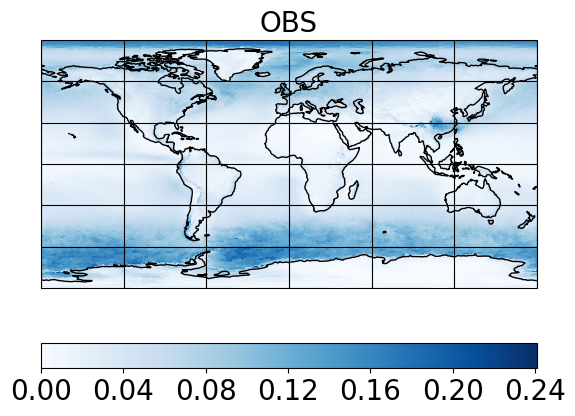

In [153]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('lwp')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = obs_avrg
psy.plot.mapplot(file_template, name='clt', time = [0], title='OBS', cmap='Blues', grid_labels = 0, titlesize=20, bounds=set_bounds(obs_avrg), \
                 cticks=set_cticks(obs_avrg), grid_labelsize=15, cticksize=20)

cdo    remapcon: YAC first order conservative weights from lonlat (720x360) to unstructured (81920) grid
RMSE = 0.04203


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr95: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

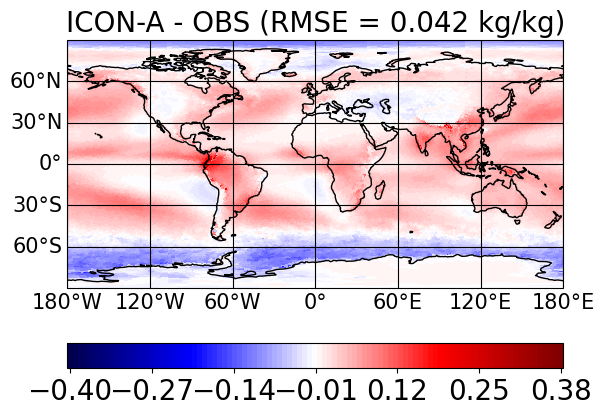

In [178]:
# Preprocess and load OBS data
obs_avrg = preprocess_obs('lwp')

# Load ICON-A data
data_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments/ag_atm_amip_r2b5_auto_tuned_baseline_20yrs/'

icona_cllvi_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').cllvi[1:]
icona_cllvi_data_avrg = icona_cllvi_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = icona_cllvi_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4g'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-A - OBS (RMSE = %.3f kg/kg)'%rmse, bounds=set_bounds(file_template.clt.values[0], div=True), \
                 cticks=set_cticks(file_template.clt.values[0], div=True), cmap='seismic',titlesize=20, grid_labelsize=15, cticksize=20)

RMSE = 0.04009


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr97: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

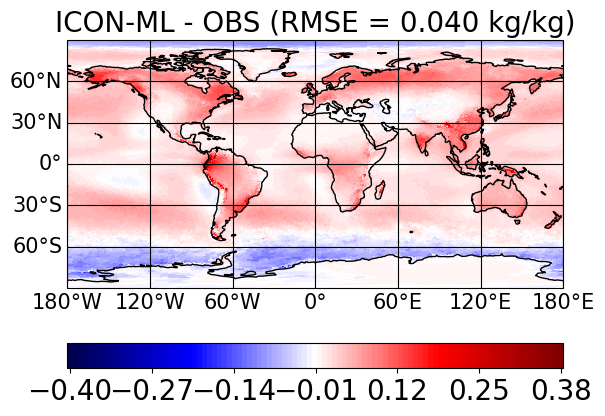

In [180]:
# Load ICON-ML data
data_path = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long/'

iconml_cllvi_data = xr.open_mfdataset(data_path + '*atm_2d_ml*.nc').cllvi[1:]
iconml_cllvi_data_avrg = iconml_cllvi_data.mean('time')

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_cllvi_data_avrg - obs_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.4g'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - OBS (RMSE = %.3f kg/kg)'%rmse, cmap='seismic',titlesize=20, bounds=set_bounds(icona_cllvi_data_avrg - obs_avrg, div=True), \
                 cticks=set_cticks(icona_cllvi_data_avrg - obs_avrg, div=True), grid_labelsize=15, cticksize=20)

RMSE = 0.022094


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr96: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

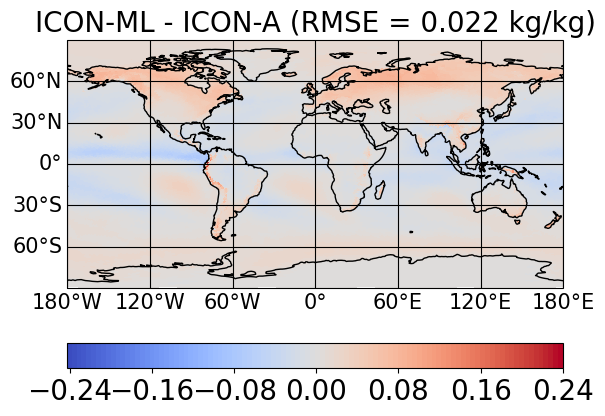

In [179]:
# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot LW radiation
file_template.clt.values[0] = iconml_cllvi_data_avrg - icona_cllvi_data_avrg
rmse = np.sqrt(np.mean((file_template.clt.values[0])**2))
print('RMSE = %.6f'%rmse)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'ICON-ML - ICON-A (RMSE = %.3f kg/kg)'%rmse, cmap='coolwarm',titlesize=20, bounds=set_bounds(obs_avrg, div=True), \
                 cticks=set_cticks(obs_avrg, div=True), grid_labelsize=15, cticksize=20)

#### Comparison of TOA balance between ICON-ML runs

We should stick to the old ICON-ML simulation (so based_on_12962670)

In [115]:
data_path1 = "/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_13084869_20yrs_241002/"
data_path2 = "/scratch/b/b309170/experiments/ag_atm_amip_r2b5_cvtfall_entrmid_05_cov15_based_on_12962670_20yrs_240927/"

N = 1
M = -1

iconml1_rsut_data = xr.open_mfdataset(data_path1 + '*atm_2d_ml*.nc').rsut[N:]
iconml2_rsut_data = xr.open_mfdataset(data_path2 + '*atm_2d_ml*.nc').rsut[N:]

iconml1_rsdt_data = xr.open_mfdataset(data_path1 + '*atm_2d_ml*.nc').rsdt[N:]
iconml2_rsdt_data = xr.open_mfdataset(data_path2 + '*atm_2d_ml*.nc').rsdt[N:]

iconml1_rlut_data = xr.open_mfdataset(data_path1 + '*atm_2d_ml*.nc').rlut[N:]
iconml2_rlut_data = xr.open_mfdataset(data_path2 + '*atm_2d_ml*.nc').rlut[N:]


print('Old ICON-ML sim: %.3f'%float(np.mean(iconml2_rsdt_data - iconml2_rsut_data - iconml2_rlut_data)))
print('New ICON-ML sim: %.3f'%float(np.mean(iconml1_rsdt_data - iconml1_rsut_data - iconml1_rlut_data)))

Old ICON-ML sim: 0.178
New ICON-ML sim: -0.229
